In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageFilter
import cv2

In [4]:
input_dir = "../data/images/"
target_dir = "../data/annotations/trimaps/"

input_img_paths =sorted([os.path.join(input_dir , fname )for fname in os.listdir(input_dir) if fname.endswith(".jpg")])
target_img_paths = sorted([os.path.join(target_dir , fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

d:\miniconda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\miniconda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted class: 285


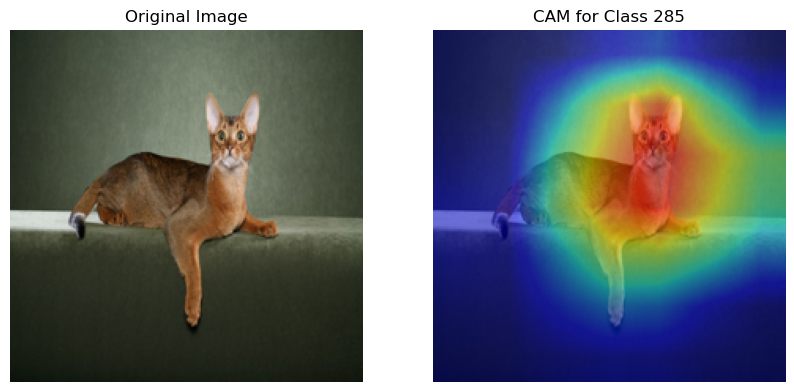

In [5]:
# loading the pretrained model
model = models.resnet50(pretrained=True)
model.eval()  

# extracting the features before gap and fc layer
class CAMExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        # obtain all the features after all the CNN
        self.features = nn.Sequential(*list(model.children())[:-2])
        # obtain the fc layer
        self.fc_weights = model.fc.weight

    def forward(self, x):
        return self.features(x)

extractor = CAMExtractor(model)



preprocess = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


# extacting features from the input image

image_path = input_img_paths[0] 
image = Image.open(image_path).convert('RGB')
input_tensor = preprocess(image).unsqueeze(0)  # [1, 3, 224, 224]


with torch.no_grad():
    features = extractor(input_tensor)  
    logits = model(input_tensor)  
    probs = F.softmax(logits, dim=1)



target_class = torch.argmax(probs).item()  
print(f"Predicted class: {target_class}")

# generating cam
cam = torch.zeros(features.shape[2:], dtype=torch.float32)  # [7, 7]
for i, w in enumerate(extractor.fc_weights[target_class]):
    cam += w * features[0, i, :, :]


cam = F.relu(cam) 
cam = cam / cam.max()  
cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)[0, 0]  


cam_np = cam.detach().numpy()  
image_np = np.array(image.resize((224, 224)))  

heatmap = plt.cm.jet(cam_np)[:, :, :3] 
overlay = (heatmap * 0.5 + image_np / 255.0 * 0.5) 

# show the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title(f"CAM for Class {target_class}")
plt.axis('off')

plt.show()

# 
plt.imsave("cam_output.png", overlay)

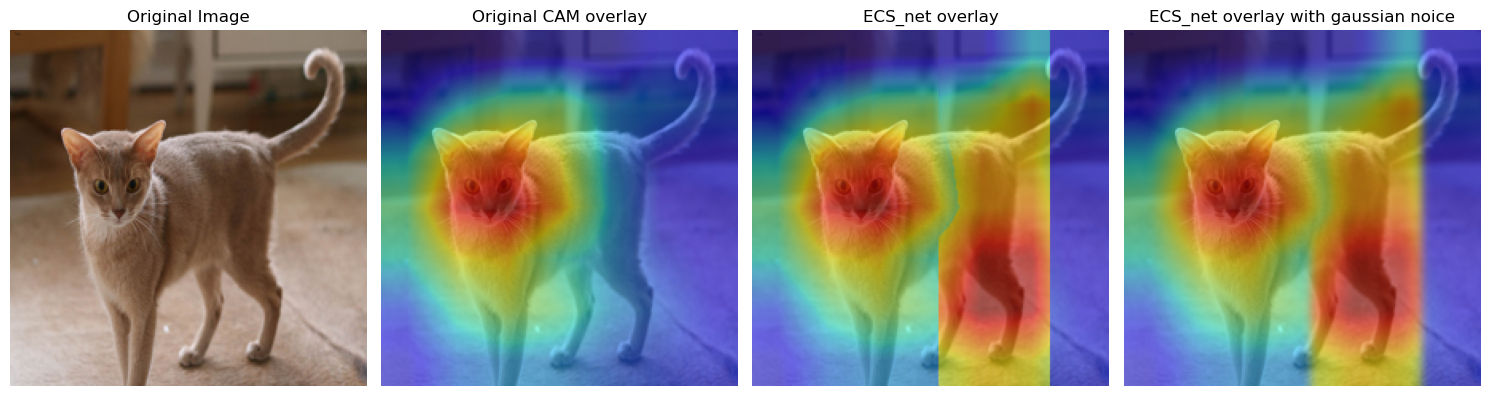

In [6]:
# basic trial of ECS-Net CAM



# same structure as ECS-Net


model = models.resnet50(pretrained=True)
model.eval()

# CAM Extractor class
class CAMExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.features = nn.Sequential(*list(model.children())[:-2])
        self.fc_weights = model.fc.weight

    def forward(self, x):
        return self.features(x)

extractor = CAMExtractor(model)

# Preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = input_img_paths[20]  # Replace with your image path
image = Image.open(image_path).convert('RGB')
input_tensor = preprocess(image).unsqueeze(0)

# Generate original CAM
with torch.no_grad():
    features = extractor(input_tensor)
    logits = model(input_tensor)
    probs = F.softmax(logits, dim=1)

target_class = torch.argmax(probs).item()

# Compute original CAM
cam = torch.zeros(features.shape[2:], dtype=torch.float32)
for i, w in enumerate(extractor.fc_weights[target_class]):
    cam += w * features[0, i, :, :]

cam = F.relu(cam)
cam = cam / cam.max()
cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)[0, 0]
original_cam_np = cam.detach().numpy()




# mask some of the original image for better final CAM
# Create erased image
mask = (original_cam_np > 0.5).astype(np.uint8)  # δ=0.6 threshold
blurred_image = image.filter(ImageFilter.GaussianBlur(radius=20))
erased_np = np.where(np.expand_dims(mask, -1), np.array(blurred_image.resize((224,224))), np.array(image.resize((224,224))))
erased_image = Image.fromarray(erased_np)

# Generate erased CAM
erased_tensor = preprocess(erased_image).unsqueeze(0)

with torch.no_grad():
    erased_features = extractor(erased_tensor)
    erased_logits = model(erased_tensor)

# Compute erased CAM
erased_cam = torch.zeros(erased_features.shape[2:], dtype=torch.float32)
for i, w in enumerate(extractor.fc_weights[target_class]):
    erased_cam += w * erased_features[0, i, :, :]

erased_cam = F.relu(erased_cam)
erased_cam = erased_cam / erased_cam.max()
erased_cam = F.interpolate(erased_cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)[0, 0]
erased_cam_np = erased_cam.detach().numpy()

# Noise suppression on erased CAM
score_map = np.max(erased_cam_np, axis=0)  # Simplified score map
suppressed_mask = (score_map > 0.8) & (mask == 0)  # θ=0.8 and exclude erased regions
final_cam = np.where(suppressed_mask, erased_cam_np, original_cam_np)

image_np = np.array(image.resize((224, 224))) 


heatmap_1 = plt.cm.jet(original_cam_np)[:, :, :3] 
overlay_1 = (heatmap_1 * 0.5 + image_np / 255.0 * 0.5) 



heatmap_2 = plt.cm.jet(final_cam)[:, :, :3]

overlay_2 = (heatmap_2 * 0.5 + image_np / 255.0 * 0.5) 

heatmap_3 = cv2.GaussianBlur(heatmap_2, (15, 15), 3)

overlay_3 = (heatmap_3 * 0.5 + image_np / 255.0 * 0.5)


# Visualization
plt.figure(figsize=(15, 5))

# Original Image and CAM
plt.subplot(1, 4, 1)
plt.imshow(image.resize((224,224)))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(overlay_1, cmap='jet')
plt.title("Original CAM overlay")
plt.axis('off')

# Erased Image and CAM
plt.subplot(1, 4, 3)
plt.imshow(overlay_2, cmap='jet')
plt.title("ECS_net overlay")
plt.axis('off')


# Erased Image and CAM
plt.subplot(1, 4, 4)
plt.imshow(overlay_3, cmap='jet')
plt.title("ECS_net overlay with gaussian noice")
plt.axis('off')


plt.tight_layout()
plt.show()